# Imports

In [1]:
########################################################################
# Python Standard Libraries
import os

########################################################################
# Numpy Library
import numpy as np # linear algebra

########################################################################
# Pandas Library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

########################################################################
# MATPLOT Library
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

########################################################################
# SKLearn Library
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc, multilabel_confusion_matrix

########################################################################
# PYLAB Library
from pylab import bone, pcolor, colorbar, plot, show, title

# Declare data path

In [2]:
data_path = '../data'
nbaiot_data_path = os.path.join(data_path, 'nbaiot')
nbaiot_20K_data_path = os.path.join(data_path, 'nbaiot_20K')
nbaiot_10K_data_path = os.path.join(data_path,'nbaiot_10K')
nbaiot_5K_data_path = os.path.join(data_path, 'nbaiot_5K')
nbaiot_1K_data_path = os.path.join(data_path, 'nbaiot_1K')

In [3]:
print(os.path.exists(nbaiot_1K_data_path))

True


In [4]:
for _, _, files in os.walk(nbaiot_1K_data_path):
    print(len(files))
#     for file in files:
#         print(file)

89


# Utility functions

In [5]:
# get all file in folders
def get_all_files(folder):
    all_files = []
    for _, _, files in os.walk(folder):
        for file in files:
            all_files.append(file)
    return sorted(all_files)

In [6]:
all_files = get_all_files(folder=nbaiot_1K_data_path)
print(len(all_files))
print(all_files[:10])

89
['1.benign.csv', '1.gafgyt.combo.csv', '1.gafgyt.junk.csv', '1.gafgyt.scan.csv', '1.gafgyt.tcp.csv', '1.gafgyt.udp.csv', '1.mirai.ack.csv', '1.mirai.scan.csv', '1.mirai.syn.csv', '1.mirai.udp.csv']


In [7]:
benign_files = [file for file in all_files if 'benign' in file]
print(len(benign_files))

mirai_files = [file for file in all_files if 'mirai' in file]
print(len(mirai_files))

gafgyt_files = [file for file in all_files if 'gafgyt' in file]
print(len(gafgyt_files))

9
35
45


In [8]:
dn_nbaiot = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell', 'Philips_B120N10_Baby_Monitor', 
             'Provision_PT_737E_Security_Camera', 'Provision_PT_838_Security_Camera', 
             'Samsung_SNH_1011_N_Webcam', 'SimpleHome_XCS7_1002_WHT_Security_Camera', 
             'SimpleHome_XCS7_1003_WHT_Security_Camera']

# Get data

In [9]:
# choosen_folder = nbaiot_1K_data_path

# # load benign
# df_benign = pd.concat(pd.read_csv(os.path.join(choosen_folder, filename)) for filename in benign_files)

# # load mirai
# df_mirai = pd.concat(pd.read_csv(os.path.join(choosen_folder, filename)) for filename in mirai_files)

# # load gafgyt
# df_gafgyt = pd.concat(pd.read_csv(os.path.join(choosen_folder, filename)) for filename in gafgyt_files)

## Test data

In [10]:
# # df_benign.head()
# df_mirai.head()
# # df_gafgyt.head()

# Minisom

In [11]:
# ********************************************************************************************************
# This is a third party implementation
# https://github.com/JustGlowing/minisom
# MiniSom by Giuseppe Vettigli is licensed under the Creative Commons Attribution 3.0 Unported License.
# To view a copy of this license, visit http://creativecommons.org/licenses/by/3.0/.
# ********************************************************************************************************

from math import sqrt

from numpy import (array, unravel_index, nditer, linalg, random, subtract,
                   power, exp, pi, zeros, arange, outer, meshgrid, dot)
from collections import defaultdict
from warnings import warn

"""
    Minimalistic implementation of the Self Organizing Maps (SOM).
"""


def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.
    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return sqrt(dot(x, x.T))

class MiniSom(object):
    def __init__(self, x, y, input_len, sigma=1.0, learning_rate=0.5, decay_function=None, random_seed=None):
        """
            Initializes a Self Organizing Maps.
            x,y - dimensions of the SOM
            input_len - number of the elements of the vectors in input
            sigma - spread of the neighborhood function (Gaussian), needs to be adequate to the dimensions of the map.
            (at the iteration t we have sigma(t) = sigma / (1 + t/T) where T is #num_iteration/2)
            learning_rate - initial learning rate
            (at the iteration t we have learning_rate(t) = learning_rate / (1 + t/T) where T is #num_iteration/2)
            decay_function, function that reduces learning_rate and sigma at each iteration
                            default function: lambda x,current_iteration,max_iter: x/(1+current_iteration/max_iter)
            random_seed, random seed to use.
        """
        if sigma >= x/2.0 or sigma >= y/2.0:
            warn('Warning: sigma is too high for the dimension of the map.')
        if random_seed:
            self.random_generator = random.RandomState(random_seed)
        else:
            self.random_generator = random.RandomState(random_seed)
        if decay_function:
            self._decay_function = decay_function
        else:
            self._decay_function = lambda x, t, max_iter: x/(1+t/max_iter)
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.weights = self.random_generator.rand(x,y,input_len)*2-1 # random initialization
        for i in range(x):
            for j in range(y):
                self.weights[i,j] = self.weights[i,j] / fast_norm(self.weights[i,j]) # normalization
        self.activation_map = zeros((x,y))
        self.neigx = arange(x)
        self.neigy = arange(y) # used to evaluate the neighborhood function
        self.neighborhood = self.gaussian

    def _activate(self, x):
        """ Updates matrix activation_map, in this matrix the element i,j is the response of the neuron i,j to x """
        s = subtract(x, self.weights) # x - w
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.activation_map[it.multi_index] = fast_norm(s[it.multi_index])  # || x - w ||
            it.iternext()

    def activate(self, x):
        """ Returns the activation map to x """
        self._activate(x)
        return self.activation_map

    def gaussian(self, c, sigma):
        """ Returns a Gaussian centered in c """
        d = 2*pi*sigma*sigma
        ax = exp(-power(self.neigx-c[0], 2)/d)
        ay = exp(-power(self.neigy-c[1], 2)/d)
        return outer(ax, ay)  # the external product gives a matrix

    def diff_gaussian(self, c, sigma):
        """ Mexican hat centered in c (unused) """
        xx, yy = meshgrid(self.neigx, self.neigy)
        p = power(xx-c[0], 2) + power(yy-c[1], 2)
        d = 2*pi*sigma*sigma
        return exp(-p/d)*(1-2/d*p)

    def winner(self, x):
        """ Computes the coordinates of the winning neuron for the sample x """
        self._activate(x)
        return unravel_index(self.activation_map.argmin(), self.activation_map.shape)

    def update(self, x, win, t):
        """
            Updates the weights of the neurons.
            x - current pattern to learn
            win - position of the winning neuron for x (array or tuple).
            t - iteration index
        """
        eta = self._decay_function(self.learning_rate, t, self.T)
        sig = self._decay_function(self.sigma, t, self.T) # sigma and learning rate decrease with the same rule
        g = self.neighborhood(win, sig)*eta # improves the performances
        it = nditer(g, flags=['multi_index'])
        while not it.finished:
            # eta * neighborhood_function * (x-w)
            self.weights[it.multi_index] += g[it.multi_index]*(x-self.weights[it.multi_index])
            # normalization
            self.weights[it.multi_index] = self.weights[it.multi_index] / fast_norm(self.weights[it.multi_index])
            it.iternext()

    def quantization(self, data):
        """ Assigns a code book (weights vector of the winning neuron) to each sample in data. """
        q = zeros(data.shape)
        for i, x in enumerate(data):
            q[i] = self.weights[self.winner(x)]
        return q

    def random_weights_init(self, data):
        """ Initializes the weights of the SOM picking random samples from data """
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.weights[it.multi_index] = data[self.random_generator.randint(len(data))]
            self.weights[it.multi_index] = self.weights[it.multi_index]/fast_norm(self.weights[it.multi_index])
            it.iternext()

    def train_random(self, data, num_iteration):
        """ Trains the SOM picking samples at random from data """
        self._init_T(num_iteration)
        for iteration in range(num_iteration):
            rand_i = self.random_generator.randint(len(data)) # pick a random sample
            self.update(data[rand_i], self.winner(data[rand_i]), iteration)

    def train_batch(self, data, num_iteration):
        """ Trains using all the vectors in data sequentially """
        self._init_T(len(data)*num_iteration)
        iteration = 0
        while iteration < num_iteration:
            idx = iteration % (len(data)-1)
            self.update(data[idx], self.winner(data[idx]), iteration)
            iteration += 1

    def _init_T(self, num_iteration):
        """ Initializes the parameter T needed to adjust the learning rate """
        self.T = num_iteration/2  # keeps the learning rate nearly constant for the last half of the iterations

    def distance_map(self):
        """ Returns the distance map of the weights.
            Each cell is the normalised sum of the distances between a neuron and its neighbours.
        """
        um = zeros((self.weights.shape[0], self.weights.shape[1]))
        it = nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                    if ii >= 0 and ii < self.weights.shape[0] and jj >= 0 and jj < self.weights.shape[1]:
                        um[it.multi_index] += fast_norm(self.weights[ii, jj, :]-self.weights[it.multi_index])
            it.iternext()
        um = um/um.max()
        return um

    def activation_response(self, data):
        """
            Returns a matrix where the element i,j is the number of times
            that the neuron i,j have been winner.
        """
        a = zeros((self.weights.shape[0], self.weights.shape[1]))
        for x in data:
            a[self.winner(x)] += 1
        return a

    def quantization_error(self, data):
        """
            Returns the quantization error computed as the average distance between
            each input sample and its best matching unit.
        """
        error = 0
        for x in data:
            error += fast_norm(x-self.weights[self.winner(x)])
        return error/len(data)

    def win_map(self, data):
        """
            Returns a dictionary wm where wm[(i,j)] is a list with all the patterns
            that have been mapped in the position i,j.
        """
        winmap = defaultdict(list)
        for x in data:
            winmap[self.winner(x)].append(x)
        return winmap


In [12]:
class Som:
    def __init__(self, x=20, y=None):
        '''
            parameter: x, y, size of the grid,
                     default: 20x20, if y is not supplied, y is the same as x
        '''
        self.som = None
        self.map_x = x
        if not y: 
            self.map_y = x # square grid
        else:
            self.map_y = y

    def fit(self, X):
        '''
            Fit SOM to the input data.
            Parameters: X = a numpy array and it should contain
                            all columns as features and any manually
                            labeled columns should be removed before
                            calling this function.
        '''
        nb_features = X.shape[1] # number of features
        som = MiniSom(x = self.map_x, y = self.map_y, input_len = nb_features, sigma = 1.0, learning_rate = 0.5)
        som.random_weights_init(X)
        som.train_random(data = X, num_iteration = 2000)
        dm = som.distance_map()
        mid = []
        for x in X:
            w = som.winner(x)
            (x,y) = w
            mid.append(dm[x][y])

        self.dm = dm
        self.som = som
        self.grid = (self.map_x, self.map_y)
        self.mid = mid

    def predict(self, threshold = 0.02, anomaly_label=0):
        '''Predict data as normal or anomalous based upon mean inter-neuron distance.
             Need to call fit() before calling this.
             Parameters: threshold = the threshold (default = 0.02) that is used to
                                     determine if normal = 1 (when mid <= threshold),
                                     or anomalous = 0 otherwise.
                         anomaly_label = the value to label anomalies, default = 0'''
        if self.som is None:
            raise Exception('Call fit() before calling this')

        y_pred = []
        for m in self.mid:
            normal = (1 if m <= threshold else anomaly_label)
            y_pred.append(normal)
        return y_pred

    def plot_marker(self, xy, m, c):
        plot(xy[0] + 0.5,
             xy[1] + 0.5,
             m,
             markeredgecolor = c,
             markerfacecolor = 'None',
             markersize = 10,
             markeredgewidth = 2)

    def plot_distance_map_labels(self, t, X, Y):
        '''Plots distance map with labels. Need to call fit() before calling this.
             Parameters: X = input features
                         Y = labels, 1 = normal, 0 = anomalous.'''
        if self.som is None:
            raise Exception('Call fit() before calling this')

        red_set = set() # normal instances
        green_set = set() # anomalous instances
        for i, x in enumerate(X):
            w = self.som.winner(x)
#             if int(Y[i]) == 0:
#                 red_set.add(w)
#             else:
#                 green_set.add(w)
            if int(Y[i]) == 1:
                red_set.add(w)
            else:
                green_set.add(w)
        bone()
        pcolor(self.dm.T)
        colorbar()
        (map_x, map_y) = self.grid
        for x in range(map_x):
            for y in range(map_y):
                xy = (x,y)
                if (xy in red_set) and (xy in green_set):
                    self.plot_marker(xy, 'h', 'y')
                elif xy in red_set:
                    self.plot_marker(xy, 'o', 'r')
                elif xy in green_set:
                    self.plot_marker(xy, 's', 'g')
                else:
                    pass #plot_marker(xy, 'v', 'b')
        title(t)
        show()

In [13]:
# Imports
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
import seaborn as sns
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

from keras.layers import Input, Dense
from keras import regularizers, Model
from keras.models import Sequential

from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc
from sklearn.datasets import make_blobs

from imageio import imwrite
#from scipy.misc import imsave

%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from PIL import Image, ImageChops

# Prepare traing & test data

In [14]:
columns = ["MI_dir_L5_weight","MI_dir_L5_mean","MI_dir_L5_variance","MI_dir_L3_weight","MI_dir_L3_mean",
           "MI_dir_L3_variance","MI_dir_L1_weight","MI_dir_L1_mean","MI_dir_L1_variance",
           "MI_dir_L0.1_weight","MI_dir_L0.1_mean","MI_dir_L0.1_variance","MI_dir_L0.01_weight",
           "MI_dir_L0.01_mean","MI_dir_L0.01_variance","H_L5_weight","H_L5_mean","H_L5_variance",
           "H_L3_weight","H_L3_mean","H_L3_variance","H_L1_weight","H_L1_mean","H_L1_variance",
           "H_L0.1_weight","H_L0.1_mean","H_L0.1_variance","H_L0.01_weight","H_L0.01_mean",
           "H_L0.01_variance","HH_L5_weight","HH_L5_mean","HH_L5_std","HH_L5_magnitude",
           "HH_L5_radius","HH_L5_covariance","HH_L5_pcc","HH_L3_weight","HH_L3_mean",
           "HH_L3_std","HH_L3_magnitude","HH_L3_radius","HH_L3_covariance","HH_L3_pcc",
           "HH_L1_weight","HH_L1_mean","HH_L1_std","HH_L1_magnitude","HH_L1_radius",
           "HH_L1_covariance","HH_L1_pcc","HH_L0.1_weight","HH_L0.1_mean","HH_L0.1_std",
           "HH_L0.1_magnitude","HH_L0.1_radius","HH_L0.1_covariance","HH_L0.1_pcc",
           "HH_L0.01_weight","HH_L0.01_mean","HH_L0.01_std","HH_L0.01_magnitude",
           "HH_L0.01_radius","HH_L0.01_covariance","HH_L0.01_pcc","HH_jit_L5_weight",
           "HH_jit_L5_mean","HH_jit_L5_variance","HH_jit_L3_weight","HH_jit_L3_mean",
           "HH_jit_L3_variance","HH_jit_L1_weight","HH_jit_L1_mean","HH_jit_L1_variance",
           "HH_jit_L0.1_weight","HH_jit_L0.1_mean","HH_jit_L0.1_variance","HH_jit_L0.01_weight",
           "HH_jit_L0.01_mean","HH_jit_L0.01_variance","HpHp_L5_weight","HpHp_L5_mean",
           "HpHp_L5_std","HpHp_L5_magnitude","HpHp_L5_radius","HpHp_L5_covariance",
           "HpHp_L5_pcc","HpHp_L3_weight","HpHp_L3_mean","HpHp_L3_std","HpHp_L3_magnitude",
           "HpHp_L3_radius","HpHp_L3_covariance","HpHp_L3_pcc","HpHp_L1_weight","HpHp_L1_mean",
           "HpHp_L1_std","HpHp_L1_magnitude","HpHp_L1_radius","HpHp_L1_covariance","HpHp_L1_pcc",
           "HpHp_L0.1_weight","HpHp_L0.1_mean","HpHp_L0.1_std","HpHp_L0.1_magnitude",
           "HpHp_L0.1_radius","HpHp_L0.1_covariance","HpHp_L0.1_pcc","HpHp_L0.01_weight",
           "HpHp_L0.01_mean","HpHp_L0.01_std","HpHp_L0.01_magnitude","HpHp_L0.01_radius",
           "HpHp_L0.01_covariance","HpHp_L0.01_pcc"]


In [15]:
from sklearn.model_selection import train_test_split

def get_training_data(index):
    if index not in range(1,10):
        raise Exception("Index must be in range [1,9]")
    device_file = [file for file in all_files if str(index) in file]
#     print(files)
    df = pd.DataFrame()
    y = []
    for i in range(len(device_file)):
        fname = str(device_file[i])
        if 'benign' in fname:
            df_c = pd.read_csv(os.path.join(nbaiot_10K_data_path, fname), usecols=columns)
        else:
            df_c = pd.read_csv(os.path.join(nbaiot_1K_data_path, fname), usecols=columns)
#         df_c = pd.read_csv(os.path.join(nbaiot_data_path, fname), usecols=columns)
        
        rows = df_c.shape[0]
        print("processing", fname, "rows =", rows)
        y_np = np.ones(rows) if 'benign' in fname else np.zeros(rows)
        df_c, _, y_np, _ = train_test_split(df_c, y,test_size=0.9, random_state=1)
        y.extend(y_np.tolist())
        df = pd.concat([df.iloc[:,:].reset_index(drop=True),
                      df_c.iloc[:rows,:].reset_index(drop=True)], axis=0)
    X = df.iloc[:,:].values
    y = np.array(y)
    return (X, y)

In [16]:
(X, y) = get_training_data(1)

processing 1.benign.csv rows = 10000
processing 1.gafgyt.combo.csv rows = 1000
processing 1.gafgyt.junk.csv rows = 1000
processing 1.gafgyt.scan.csv rows = 1000
processing 1.gafgyt.tcp.csv rows = 1000
processing 1.gafgyt.udp.csv rows = 1000
processing 1.mirai.ack.csv rows = 1000
processing 1.mirai.scan.csv rows = 1000
processing 1.mirai.syn.csv rows = 1000
processing 1.mirai.udp.csv rows = 1000
processing 1.mirai.udpplain.csv rows = 1000


In [17]:
X[-10:], y[-10:]

(array([[1.25468095e+02, 5.48472354e+02, 2.70010198e+03, ...,
         2.79396772e-09, 0.00000000e+00, 0.00000000e+00],
        [1.26466851e+02, 5.48516063e+02, 2.67899140e+03, ...,
         2.85217538e-09, 0.00000000e+00, 0.00000000e+00],
        [1.27465910e+02, 5.48559085e+02, 2.65820817e+03, ...,
         2.79396772e-09, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.28071203e+02, 5.48770113e+02, 2.55621229e+03, ...,
         2.91038305e-09, 0.00000000e+00, 0.00000000e+00],
        [1.29069933e+02, 5.48810633e+02, 2.53661770e+03, ...,
         2.96859071e-09, 0.00000000e+00, 0.00000000e+00],
        [1.28938672e+02, 5.48850880e+02, 2.51715188e+03, ...,
         3.02679837e-09, 0.00000000e+00, 0.00000000e+00]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [18]:
len(X), len(y)

(20000, 20000)

# SOM training

X.shape (20000, 115) y.shape (20000,)


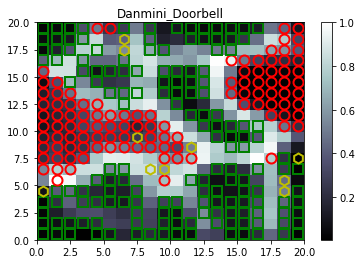

In [19]:
# get device name
device_name = dn_nbaiot[0]
print('X.shape', X.shape, 'y.shape', y.shape)
X_std = StandardScaler().fit_transform(X)
som = Som()
som.fit(X_std)
som.plot_distance_map_labels(device_name, X_std, y)
# step = 0.01

In [20]:
# # get device name
# device_name = dn_nbaiot[0]
# print('X.shape', X.shape, 'y.shape', y.shape)
# X_std = StandardScaler().fit_transform(X)
# som = Som()
# som.fit(X_std)
# som.plot_distance_map_labels(device_name, X_std, y)
# # step = 0.01
step = 0.05
threshold = 0.0
i = 1
print(device_name)
print("threshold    |  acc   |  tn  |   fp   |   fn   |   tp")
while threshold <= 1:
    y_pred = som.predict(threshold)
    tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
    acc = accuracy_score(y, y_pred)
    print(f'{threshold:.2f} | {acc:.2f} | {tn} | {fp} | {fn} | {tp}')
    threshold += step
    i += 1

Danmini_Doorbell
threshold    |  acc   |  tn  |   fp   |   fn   |   tp
0.00 | 0.50 | 10000 | 0 | 10000 | 0
0.05 | 0.54 | 6980 | 3020 | 6108 | 3892
0.10 | 0.50 | 5519 | 4481 | 5574 | 4426
0.15 | 0.45 | 4101 | 5899 | 5023 | 4977
0.20 | 0.45 | 3420 | 6580 | 4369 | 5631
0.25 | 0.44 | 2642 | 7358 | 3865 | 6135
0.30 | 0.44 | 2156 | 7844 | 3288 | 6712
0.35 | 0.44 | 1760 | 8240 | 2967 | 7033
0.40 | 0.43 | 951 | 9049 | 2257 | 7743
0.45 | 0.47 | 731 | 9269 | 1276 | 8724
0.50 | 0.49 | 642 | 9358 | 782 | 9218
0.55 | 0.50 | 525 | 9475 | 600 | 9400
0.60 | 0.50 | 395 | 9605 | 385 | 9615
0.65 | 0.49 | 180 | 9820 | 321 | 9679
0.70 | 0.50 | 102 | 9898 | 141 | 9859
0.75 | 0.49 | 22 | 9978 | 122 | 9878
0.80 | 0.50 | 22 | 9978 | 42 | 9958
0.85 | 0.50 | 10 | 9990 | 42 | 9958
0.90 | 0.50 | 0 | 10000 | 27 | 9973
0.95 | 0.50 | 0 | 10000 | 1 | 9999


# Anomaly detect (zero-day)

We use the trained model to detect new data on other device

In [21]:
device_index = 2
(X_new, y_new) = get_training_data(device_index)

processing 2.benign.csv rows = 10000
processing 2.gafgyt.combo.csv rows = 1000
processing 2.gafgyt.junk.csv rows = 1000
processing 2.gafgyt.scan.csv rows = 1000
processing 2.gafgyt.tcp.csv rows = 1000
processing 2.gafgyt.udp.csv rows = 1000
processing 2.mirai.ack.csv rows = 1000
processing 2.mirai.scan.csv rows = 1000
processing 2.mirai.syn.csv rows = 1000
processing 2.mirai.udp.csv rows = 1000
processing 2.mirai.udpplain.csv rows = 1000


X_new.shape (20000, 115) y_new.shape (20000,)


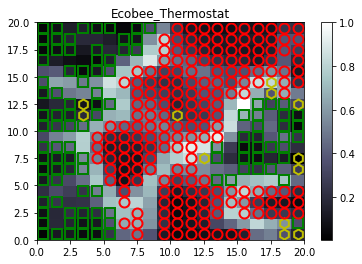

In [22]:
# get device name
device_name = dn_nbaiot[1]
print('X_new.shape', X_new.shape, 'y_new.shape', y_new.shape)
X_new_std = StandardScaler().fit_transform(X_new)
som = Som()
som.fit(X_new_std)
som.plot_distance_map_labels(device_name, X_new_std, y_new)

In [23]:
step = 0.05
threshold = 0.0
i = 1
print(device_name)
print("threshold   |  acc  |  tn  |  fp  |  fn  |  tp")
while threshold <= 1:
    y_pred = som.predict(threshold)
    tn, fp, fn, tp = confusion_matrix(y_new, y_pred, labels=[0,1]).ravel()
    acc = accuracy_score(y_new, y_pred)
    print(f'{threshold:.2f} | {acc:.2f} | {tn} | {fp} | {fn} | {tp}')
    threshold += step
    i += 1

Ecobee_Thermostat
threshold   |  acc  |  tn  |  fp  |  fn  |  tp
0.00 | 0.50 | 10000 | 0 | 10000 | 0
0.05 | 0.40 | 7229 | 2771 | 9267 | 733
0.10 | 0.36 | 5670 | 4330 | 8527 | 1473
0.15 | 0.36 | 4121 | 5879 | 6852 | 3148
0.20 | 0.37 | 3044 | 6956 | 5702 | 4298
0.25 | 0.39 | 2033 | 7967 | 4241 | 5759
0.30 | 0.44 | 1963 | 8037 | 3237 | 6763
0.35 | 0.43 | 1387 | 8613 | 2802 | 7198
0.40 | 0.42 | 713 | 9287 | 2240 | 7760
0.45 | 0.45 | 660 | 9340 | 1750 | 8250
0.50 | 0.46 | 419 | 9581 | 1179 | 8821
0.55 | 0.47 | 277 | 9723 | 788 | 9212
0.60 | 0.48 | 261 | 9739 | 693 | 9307
0.65 | 0.48 | 163 | 9837 | 538 | 9462
0.70 | 0.49 | 3 | 9997 | 189 | 9811
0.75 | 0.49 | 2 | 9998 | 175 | 9825
0.80 | 0.50 | 2 | 9998 | 76 | 9924
0.85 | 0.50 | 0 | 10000 | 17 | 9983
0.90 | 0.50 | 0 | 10000 | 14 | 9986
0.95 | 0.50 | 0 | 10000 | 0 | 10000
